In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from curvefit.core.model import CurveModel
from curvefit.core.functions import ln_gaussian_cdf, gaussian_cdf
from scipy.stats import norm

In [2]:
# Fetches the data from the COVID19India website
class DataFetcher:
    def __init__(self, url="https://api.covid19india.org/data.json"):
        self.url = url
        self.json_data = None
        self.cases_time_series = None
        
    def fetch(self):
        r = requests.get(url=self.url)
        self.json_data = r.json()
        
        # Get the fields
        fields = list(self.json_data['cases_time_series'][0].keys())
        self.cases_time_series = {}
        
        for field in fields:
            if field == 'date':
                self.cases_time_series[field] = [x[field] for x in self.json_data['cases_time_series']]
            else:
                self.cases_time_series[field] = np.array([float(x[field]) for x in self.json_data['cases_time_series']])

In [3]:
fetcher = DataFetcher()
fetcher.fetch()

In [4]:
offset = 40 # Neglect the first 40 observati
df = pd.DataFrame()
df['death_rate'] = fetcher.cases_time_series['dailydeceased'][40:].cumsum()
df['time'] = np.arange(df['death_rate'].shape[0])
df['ln_death_rate'] = np.log(df['death_rate'] + 1)
df['group'] = 'all'
df['intercept'] = 1.0

<h2>Model fit for cumulative number of deaths in India</h2>

<h3>Single Gaussian Atom</h3>

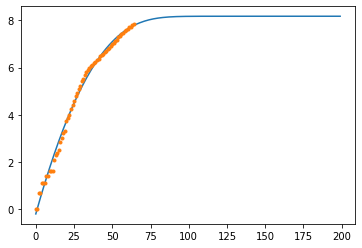

In [5]:
# Set up the CurveModel
model = CurveModel(
    df=df,
    col_t='time',
    col_obs='ln_death_rate',
    col_group='group',
    col_covs=[['intercept'], ['intercept'], ['intercept']],
    param_names=['alpha', 'beta', 'p'],
    link_fun=[lambda x: np.exp(x), lambda x: x, lambda x: np.exp(x)],
    var_link_fun=[lambda x: x, lambda x: x, lambda x: x],
    fun=ln_gaussian_cdf
)

# Fit the model to estimate parameters
model.fit_params(
    fe_init=[-3, 100, 1],
    options={
        'ftol': 1e-14,
        'maxiter': 500
    },
    re_bounds= [[0, 0]] * 3
)

# Get predictions
y_pred = model.predict(
    t=np.arange(200),
    group_name=df.group.unique()
)

# Normal value
alpha = 0.035
beta = 100
p = 10 ** 5

# Plot results
plt.plot(np.arange(200), y_pred, '-')
plt.plot(df.time, df.ln_death_rate, '.')
plt.show()

In [6]:
params = np.squeeze(model.params)
print(params)

[4.37250751e-02 5.66861507e+01 3.56886316e+03]


<h3>13 Gaussian Atoms with staggered peaks</h3>

In [7]:
X = np.zeros((df.time.shape[0], 13))
y = df.ln_death_rate
params[2] -= 12

for j in range(13):
    X[:, j] = ln_gaussian_cdf(df.time, params)
    params[2] += 2

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
reg = LinearRegression(fit_intercept=False)
reg.fit(X, y)
weights = reg.coef_

In [10]:
preds = X @ weights

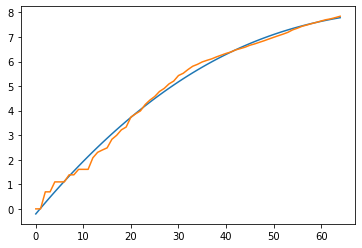

In [11]:
plt.plot(preds)
plt.plot(df.ln_death_rate)
plt.show()

<h2>Model fit for cumulative number of deaths in MH</h2>

In [37]:
class DataFetcherState:
    """Fetch data for all states"""
    
    def __init__(self):
        self.data = None
        self.raw_data = None
    
    def fetch(self):
        # Fetch the raw data
        r = requests.get(url="https://api.covid19india.org/states_daily.json")
        self.raw_data = r.json()
        self.data = {}
        
        # Iterate over the days and record the data
        for entry in self.raw_data['states_daily']:
            status = entry['status'].lower()
            for state in entry:
                if state == "date" or state == "status":
                    continue
                    
                if state not in self.data:
                    # Initialize this state
                    self.data[state] = {
                        'deceased': [],
                        'recovered': [],
                        'confirmed': []
                    }
                
                # Append the data
                self.data[state][status].append(entry[state])

fetcher = DataFetcherState()
fetcher.fetch()

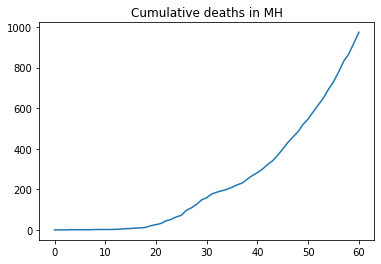

In [47]:
death_rate = np.array(fetcher.data['mh']['deceased'], dtype=float)
plt.plot(np.cumsum(death_rate))
plt.title("Cumulative deaths in MH")
plt.show()

<h2>Single Gaussian Atom</h2>

In [48]:
df = pd.DataFrame()
df['death_rate'] = np.cumsum(death_rate)
df['time'] = np.arange(df['death_rate'].shape[0])
df['ln_death_rate'] = np.log(df['death_rate'] + 1)
df['group'] = 'all'
df['intercept'] = 1.0

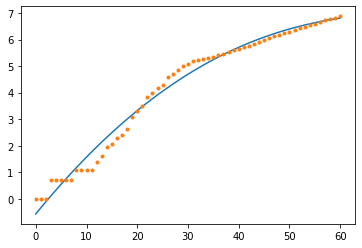

In [55]:
# Set up the CurveModel
model = CurveModel(
    df=df,
    col_t='time',
    col_obs='ln_death_rate',
    col_group='group',
    col_covs=[['intercept'], ['intercept'], ['intercept']],
    param_names=['alpha', 'beta', 'p'],
    link_fun=[lambda x: np.exp(x), lambda x: x, lambda x: np.exp(x)],
    var_link_fun=[lambda x: x, lambda x: x, lambda x: x],
    fun=ln_gaussian_cdf
)

# Fit the model to estimate parameters
model.fit_params(
    fe_init=[-3, 100, 1],
    options={
        'ftol': 1e-14,
        'maxiter': 500
    },
    re_bounds= [[0, 0]] * 3
)

# Get predictions
y_pred = model.predict(
    t=df.time,
    group_name=df.group.unique()
)

# Normal value
alpha = 0.035
beta = 100
p = 10 ** 5

# Plot results
plt.plot(y_pred, '-')
plt.plot(df.time, df.ln_death_rate, '.')
plt.show()

<h2>Multiple Gaussian Atoms</h2>

In [60]:
X = np.zeros((df.time.shape[0], 13))
y = df.ln_death_rate
params[2] -= 12

for j in range(13):
    X[:, j] = ln_gaussian_cdf(df.time, params)
    params[2] += 2

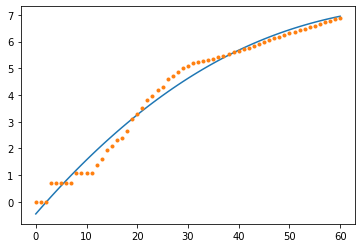

In [61]:
reg = LinearRegression(fit_intercept=False)
reg.fit(X, y)
weights = reg.coef_

preds = X @ weights

plt.plot(preds)
plt.plot(df.time, df.ln_death_rate, '.')
plt.show()